In [1]:
#do a quick clustering for the whole dataset
import scanpy as sc #for scanpy >= 1.3.7
import anndata as ann
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
import logging
import os
import glob
import matplotlib
import math

In [6]:
def pca_elbow(adata, n_genes, n_pca_pcs, name):
    rcParams['figure.figsize']=(8,8)
    rcParams['font.size']=16
    
    sc.pp.highly_variable_genes(adata, flavor='cell_ranger', n_top_genes=n_genes)
    sc.pp.pca(adata, n_comps=n_pca_pcs, use_highly_variable=True, svd_solver='arpack')
    sc.pl.pca_variance_ratio(adata, log=False, save = '_{}.png'.format(name))
    
def removegenes(adata):
    """remove human HLA genes from the dataset 
    Parameters:
    ----------
    adata: scanpy.adata
        scanpy adata object

    Returns:
    -------
    temp: scanpy.adata
        scanpy adata object
    """
    IGKV = [x for x in adata.var_names if x.startswith('IGKV')]
    IGHV = [x for x in adata.var_names if x.startswith('IGHV')]
    IGLV = [x for x in adata.var_names if x.startswith('IGLV')]
    IGLC = [x for x in adata.var_names if x.startswith('IGLC')]
    IGLL = [x for x in adata.var_names if x.startswith('IGLL')]
    IGKC = [x for x in adata.var_names if x.startswith('IGKC')]
    IGHC = [x for x in adata.var_names if x.startswith('IGHC')]
    TRAV = [x for x in adata.var_names if x.startswith('TRAV')]
    TRBV = [x for x in adata.var_names if x.startswith('TRBV')]
    
    exclude = IGKV + IGHV + IGLV + IGKC + IGHC + IGLL + IGLC+TRAV + TRBV 
    gene = [x for x in adata.var_names if x not in exclude]
    temp = adata[:,gene].copy()
    return(temp)
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score


def sil_cal(adata, res_list, n_knn_pcs):
    key_list = []
    for res in res_list:
        key_list.append('res_{}'.format(res))
        sc.tl.leiden(adata, resolution=res, key_added = 'res_{}'.format(res))
        
    pca_matrix = adata.obsm['X_pca'][:,0:n_knn_pcs]
    sil_df = pd.DataFrame(index = adata.obs.index, columns = key_list)
    info_df = pd.DataFrame(index = key_list, columns = ['n_clusters', 'sil_avg', 'res'])
    
    info_df['res'] = res_list
    
    for res_name in key_list:
        
        labels = adata.obs[res_name].to_numpy(dtype = int)
        n_clusters = len(adata.obs[res_name].unique())
        
        info_df.loc[res_name, 'n_clusters'] = n_clusters
        
        if labels.sum() == 0:
            print('At resolution {} only 1 cluster is defined, skip to the next resolution'.format(res_name.split('_')[1]))
            sil_df[res_name] = 0
            info_df.loc[res_name, 'sil_avg'] = 0
            continue
        else:
            silhouette_avg = silhouette_score(pca_matrix, adata.obs[res_name].to_numpy(dtype = int))
            sample_silhouette_values = silhouette_samples(pca_matrix, adata.obs[res_name].to_numpy(dtype = int))
            sil_df[res_name] = sample_silhouette_values
            info_df.loc[res_name, 'sil_avg'] = silhouette_avg
            print('At resolution {} the average silhouette score is {}'.format(res_name.split('_')[1], silhouette_avg))
            
    return(sil_df, info_df)

def summary_plot(info_df, path, name):
    temp_df = info_df.loc[info_df.sil_avg != 0]
    
    rcParams['figure.figsize']=(20,10)
    rcParams['font.size']=22
    fig, (ax1, ax2) = plt.subplots(1, 2)
    sb.scatterplot(data = temp_df, x = 'res', y = 'sil_avg',s =200, 
                   alpha = 0.5, color = 'black', edgecolor = 'k', ax = ax1)
    sb.scatterplot(data = temp_df, x = 'n_clusters', y = 'sil_avg',s =200, alpha = 0.5, 
                   color = 'black', edgecolor = 'k', ax = ax2)
    
    ax1.set_xlabel("Resolution")
    ax1.set_ylabel("Average silhouette score")
    ax2.set_xlabel("Cluster numbers")
    ax2.set_ylabel("Average silhouette score")

    save_dir = os.path.join(path, name)
    fig.savefig(save_dir, bbox_inches='tight')
#   plt.close()


In [3]:
adata_savepath = '/domino/edv/id-td-virology/Zhiyuan/public/Gut_remap/processed_data/annotated.h5ad'
adata= sc.read_h5ad(adata_savepath)

In [4]:
adata_high = adata[adata.obs.cell_quality == 'high'].copy()

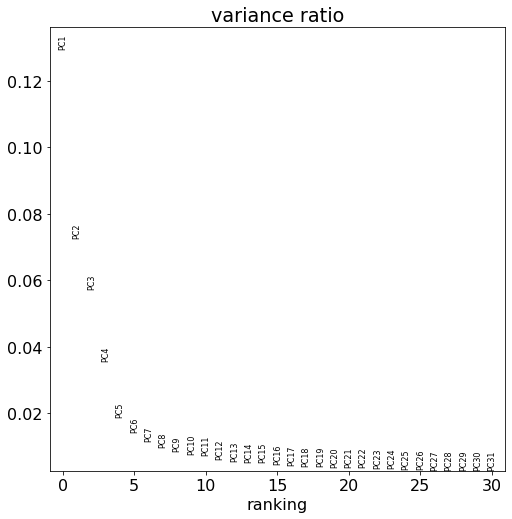

At resolution 0.3 the average silhouette score is 0.33010584115982056
At resolution 0.6 the average silhouette score is 0.22018224000930786
At resolution 1 the average silhouette score is 0.20181904733181


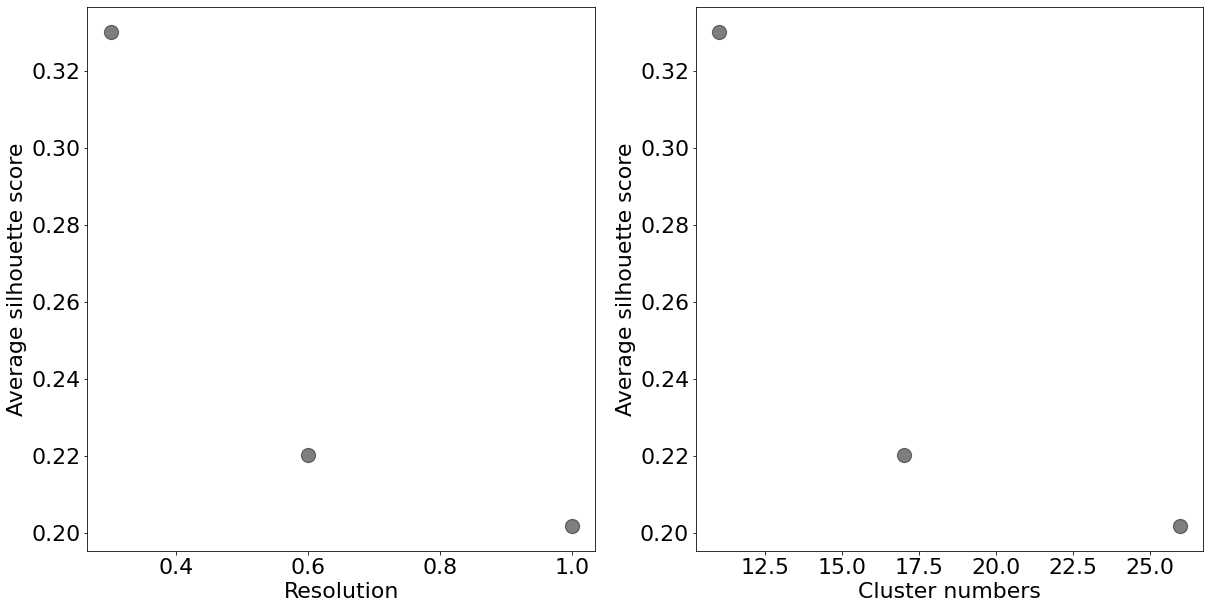

In [7]:
adata_high = removegenes(adata_high)
sc.pp.filter_genes(adata_high,min_cells=3)
sc.pp.normalize_total(adata_high, target_sum=1e4)
sc.pp.log1p(adata_high)
sc.settings.figdir = '/domino/edv/id-td-virology/Zhiyuan/public/Gut_remap/figure/T_cells/'
pca_elbow(adata_high, 2000, 50, 'total')
sc.external.pp.bbknn(adata_high, batch_key='tissue', neighbors_within_batch=10, n_pcs=10)
res_list = [0.3, 0.6, 1]
temp_adata = adata_high.copy()
test_df, info_df = sil_cal(temp_adata, res_list, n_knn_pcs = 10)
figpath = '/domino/edv/id-td-virology/Zhiyuan/public/Gut_remap/figure/T_cells/'
summary_plot(info_df, figpath, 'sil_summary_total.png')

In [8]:
path = '/domino/edv/id-td-virology/Zhiyuan/public/Gut_remap/processed_data/adata_high_cluster.h5ad'
adata_high.write(path)

In [9]:
#try resolution 0.6
adata_high.obs['leiden_r0.6'] = temp_adata.obs['res_0.6']
sc.tl.umap(adata_high)

In [18]:
adata_high.obs.GeneralAnnotation.unique()

['CD3+', 'NK', 'Doublets', 'Proliferating', 'Macrophage', ..., 'Plasma', 'DC', 'LSECs', 'Monocyte', 'Platelets']
Length: 11
Categories (11, object): ['B-cell', 'CD3+', 'DC', 'Doublets', ..., 'NK', 'Plasma', 'Platelets', 'Proliferating']

In [10]:
remove = ['Doublets', 'Proliferating', 'CD3+']
adata_high_2 = adata_high[~adata_high.obs.SecondAnnotation.isin(remove)].copy()

In [2]:
savepath = '/domino/edv/id-td-virology/Zhiyuan/public/Gut_remap/processed_data/adata_high_cluster.h5ad'
adata_high = sc.read_h5ad(savepath)

savepath = '/domino/edv/id-td-virology/Zhiyuan/public/Gut_remap/processed_data/CD8.h5ad'
adata_CD8 = sc.read_h5ad(savepath)

In [11]:
adata_high_2.obs.loc[adata_CD8.obs.index, 'SecondAnnotation'] = 'CD8+'

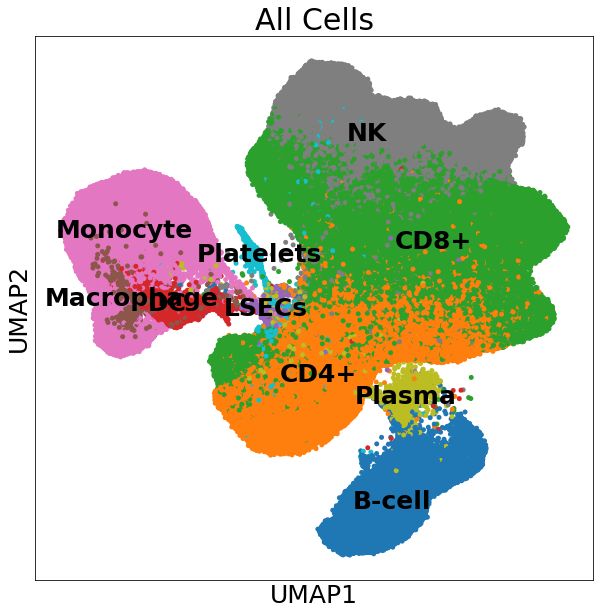

In [19]:
sc.settings.figdir = '/domino/edv/id-td-virology/Zhiyuan/public/Gut_remap/figure/T_cells/'

rcParams['figure.figsize']=(10,10)
rcParams['font.size']=25
sc.pl.umap(adata_high_2, color=['SecondAnnotation'],wspace = 0.4, title = 'All Cells', 
           s =100, ncols = 1, use_raw = False, legend_loc = 'on data', save = 'total.png')